# Udacity Machine Learning Engineer Nanodegree

# Capstone Project
This is project 5 of MLND Term 2 <br>
Author: Siddhant Tandon <br>
Date: August 14th, 2019

 ## <font color = blue> Pima Female Indians Diabetes Prediction </font>
 ***

### Exploring Data and Analysis

In [433]:
# Importing Python libraries for use later

import pandas as pd
import numpy as np

# libraries for Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)


# Data processing, metrics and modeling
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as XGBC
from sklearn.svm import LinearSVC as LSVC
from sklearn.tree import DecisionTreeClassifier as DTClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.metrics import roc_curve,auc, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score


# Stats
import matplotlib.pyplot as plt

In [434]:
from sklearn.metrics import f1_score, make_scorer

# Load the diabetes dataset
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### Outcome Variable Visualization

In [435]:
import plotly.graph_objects as go

D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

#------------COUNT-----------------------
def diabetic_count():
    trace = go.Bar( x = data['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'lightgreen'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [436]:
diabetic_count()
plt.savefig('Datavisual1.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

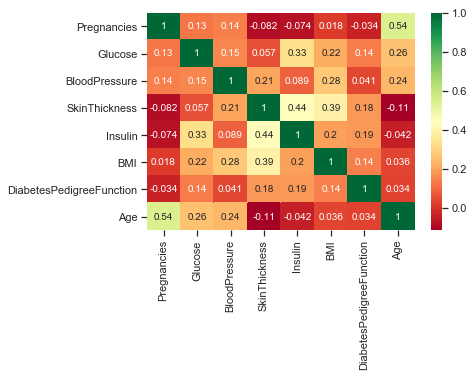

In [437]:
# to see the correlation before going into data preprocessing
import seaborn as sns

sns.heatmap(data[data.columns[:8]].corr(), annot = True, cmap = 'RdYlGn')
plt.show
plt.savefig('free.png', bbox_inches='tight')

In [438]:
# Statistical description of the dataset is done here


display(data.describe())

n_patients = data.shape[0]

n_features = data.shape[1] - 1 # Need to remove one to account for target column

# Calculate diabetic patients
n_diabetic = data['Outcome'].value_counts()[1]

# Calculate non diabetic
n_not_diabetic = data['Outcome'].value_counts()[0]

# Calculate rate
diabetic_rate = (100.0/n_patients) * n_diabetic

# Print the results
print ("Total number of patients: {}".format(n_patients))
print ("Number of features: {}".format(n_features))
print ("Number of patients with diabetes: {}".format(n_diabetic))
print ("Number of patients without diabetes: {}".format(n_not_diabetic))
print ("Rate of diabetes in dataset: {}%".format(diabetic_rate))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Total number of patients: 768
Number of features: 8
Number of patients with diabetes: 268
Number of patients without diabetes: 500
Rate of diabetes in dataset: 34.895833333333336%


#### Correlation between features

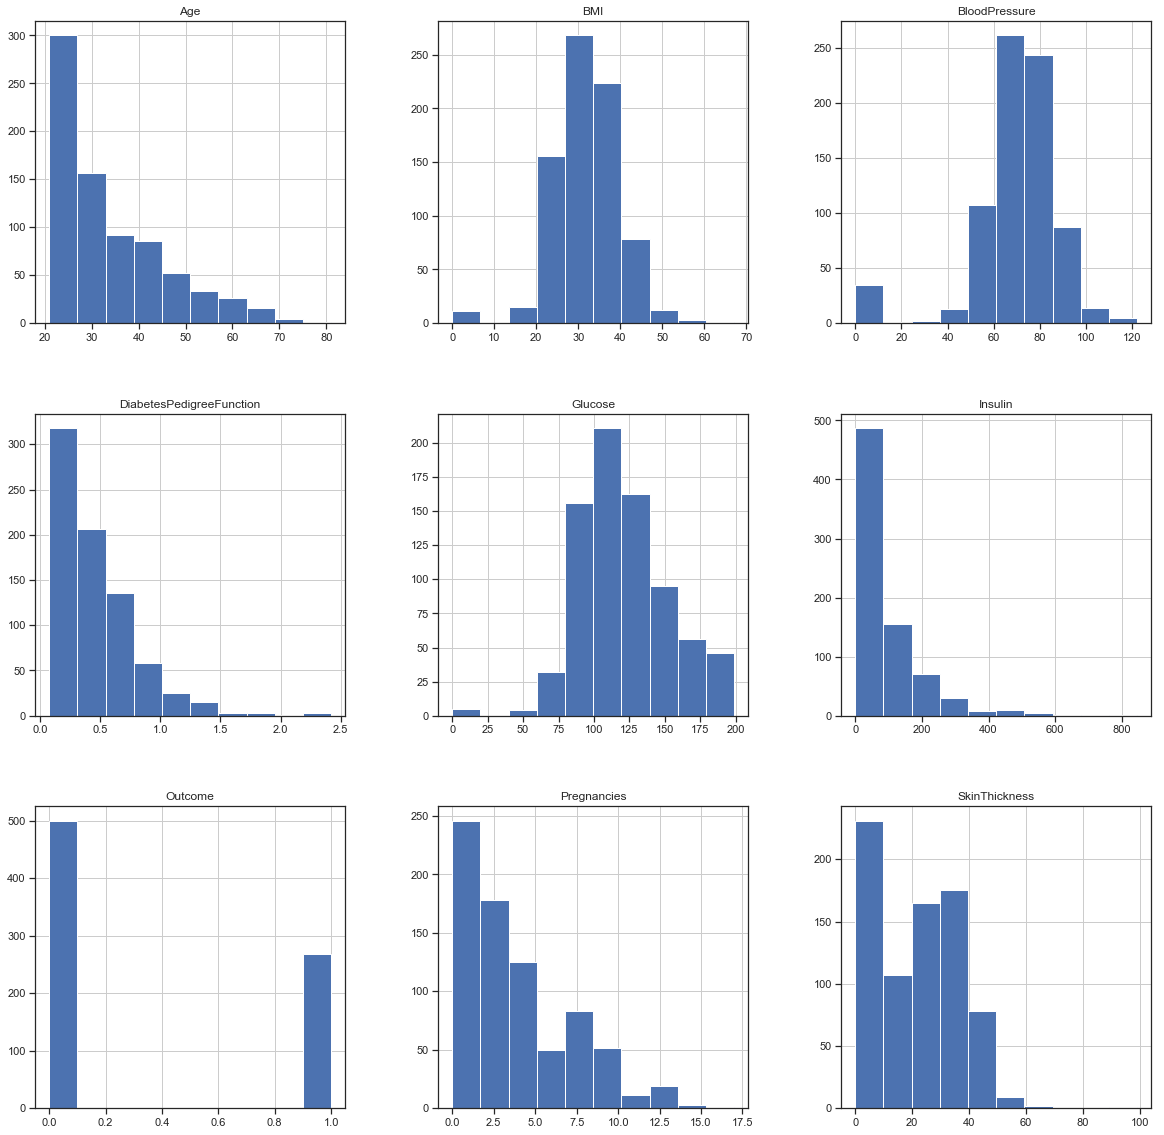

In [439]:
# visual representation of the features

p = data.hist(figsize = (20,20))
plt.savefig('Datavisual3.png', bbox_inches='tight')

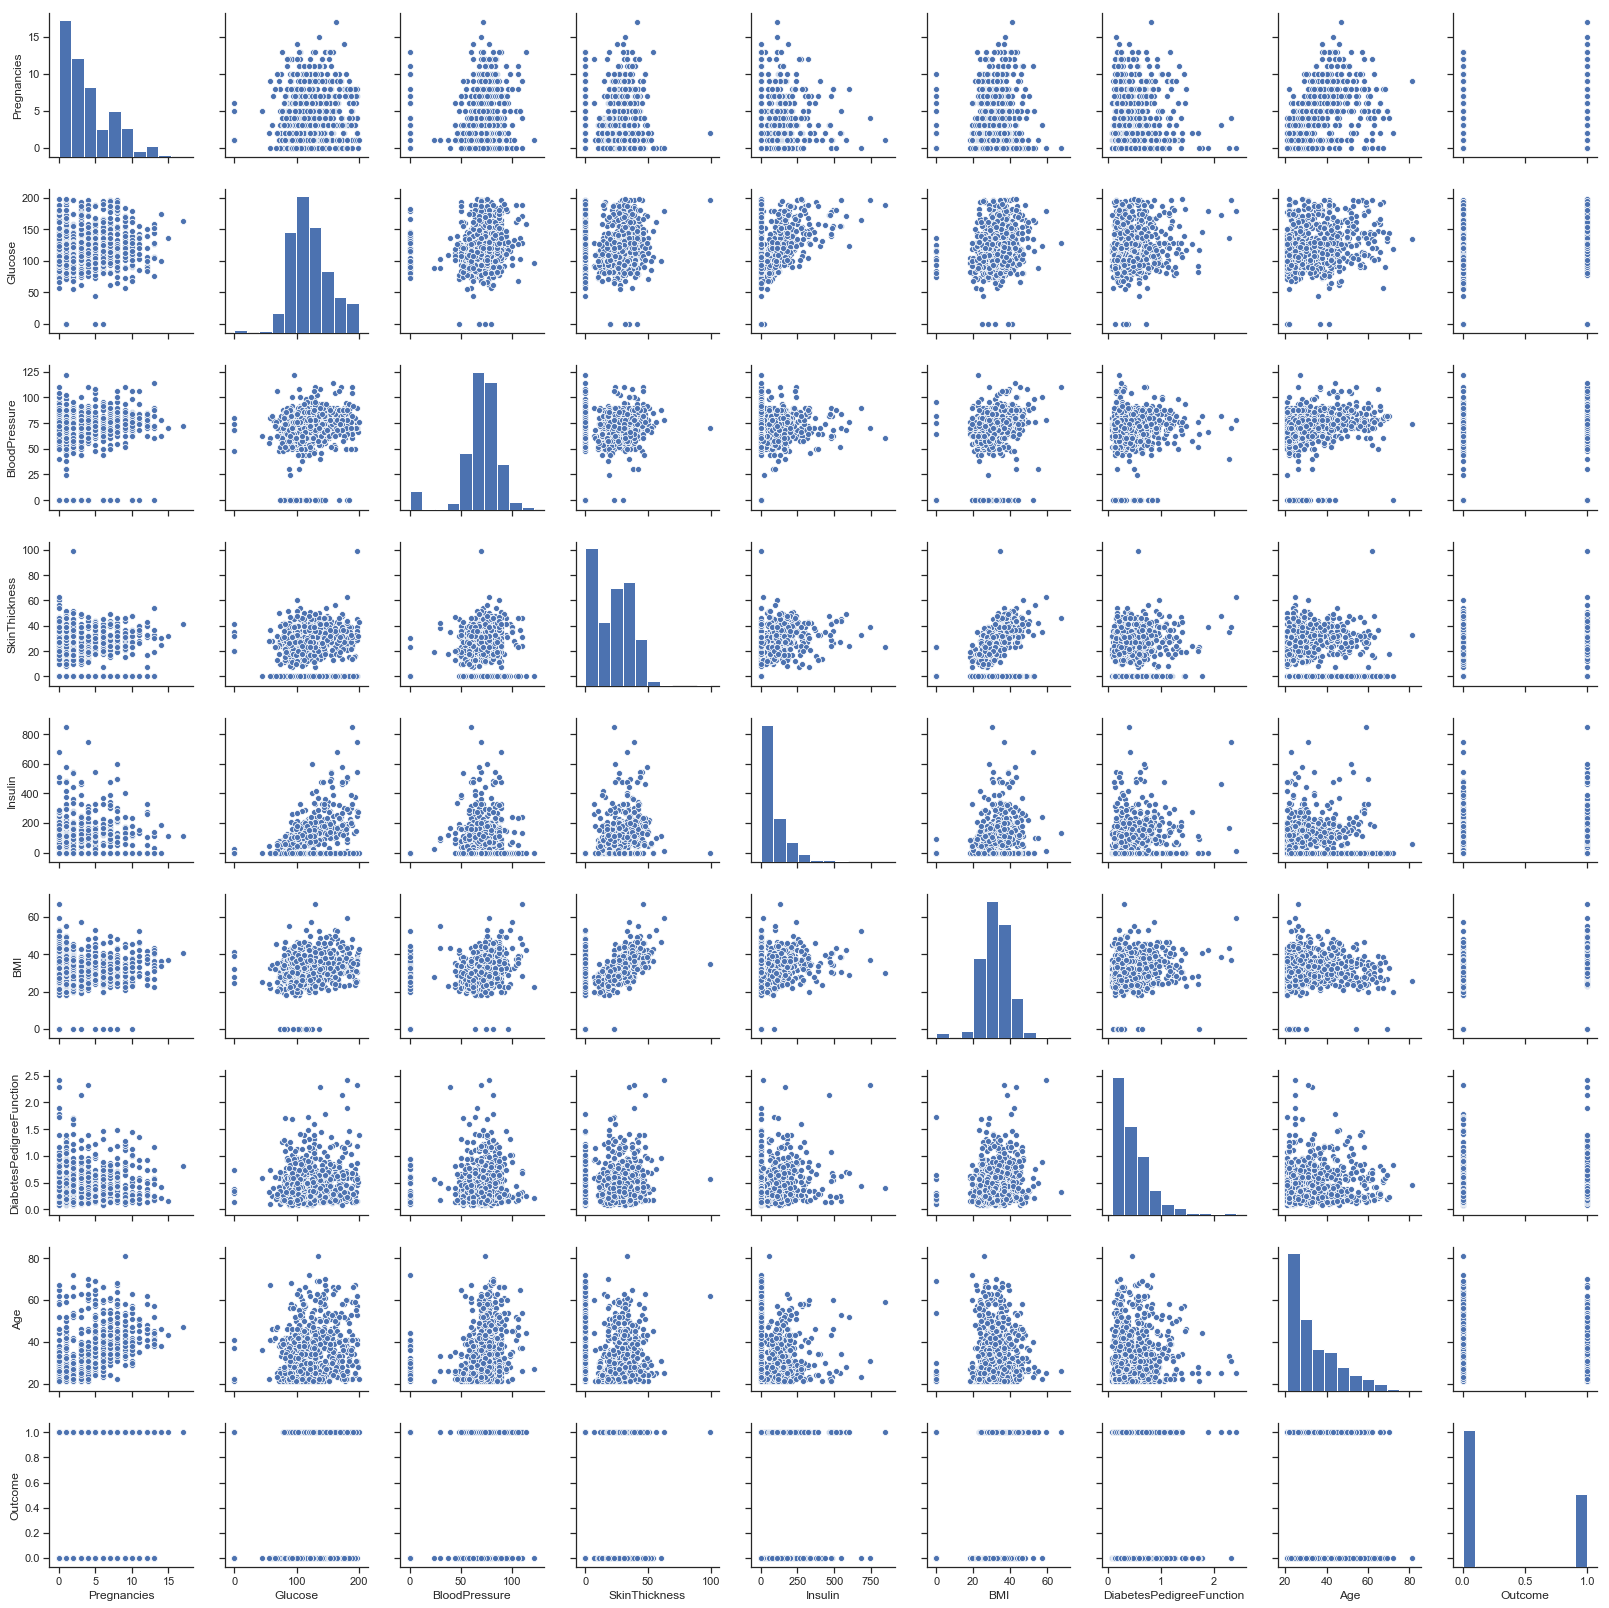

In [440]:
# another correlation plot with diagonal historgrams
import seaborn as sns

sns.set(style= "ticks")
sns.pairplot(data)
plt.savefig('Datavisual2.jpg', bbox_inches='tight')

### Data Preprocessing

#### Missing Values

In [441]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [442]:
# Define missing plot to detect all missing values in dataset
def missing_chart(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [443]:
missing_chart(data, 'Outcome')
plt.savefig('missing1.jpg', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

Missing vlaues:
- Insulin = 374
- SkinThickness = 227
- BloodPressure = 35
- BMI = 11
- Glucose = 5

In [444]:
def median_feature(var):   
    place = data[data[var].notnull()]
    place = place[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return place

In [445]:
median_feature('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


In [446]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

In [447]:
median_feature('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [448]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

In [449]:
median_feature('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [450]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

In [451]:
median_feature('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [452]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

In [453]:
median_feature('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [454]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

#### Corrected Missing Values

In [455]:
missing_chart(data, 'Outcome')
plt.savefig('missing2.jpg', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

### Model Comparison

In [456]:
# confusion matrix code for generating visuals
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [471]:
# this is where we initialize the preliminary model comparison

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(data.drop('Outcome',axis=1),data['Outcome'],test_size=0.20,random_state=42)

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness'\
            , 'BMI', 'Age', 'Insulin', 'DiabetesPedigreeFunction']
target = 'Outcome'
classifiers = [
    KNNC(),
    DTClassifier(),
    LSVC(),
    LR(),
    GNB()

]
classifier_names = [
    'K nearest neighbors',
    'Decision Tree Classifier',
    'Linear SVC ',
    'Logistic Regression',
    'Gaussian Naive Bayes'

]


In [472]:
# this is the execution file for above
for clf, clf_name in zip(classifiers, classifier_names):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores = f1_score(y_test, y_pred)
    print(clf_name, scores)

K nearest neighbors 0.7678571428571429
Decision Tree Classifier 0.7758620689655172
Linear SVC  0.21874999999999994
Logistic Regression 0.673076923076923
Gaussian Naive Bayes 0.6785714285714286


C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Confusion Matrices for the Models Above

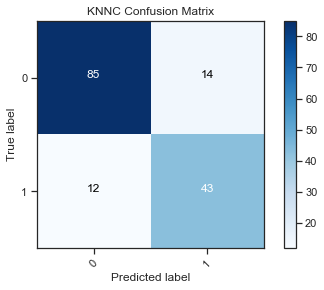

In [460]:
import itertools
model = KNNC() # adding n_neighbors parameter to see the difference
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_mtx = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2), title = 'KNNC Confusion Matrix')
plt.savefig('knnc_conf.jpg', bbox_inches='tight')

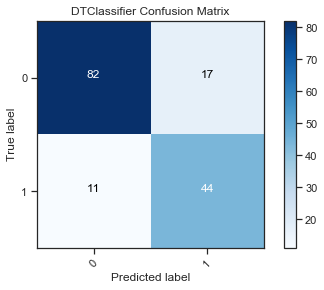

In [461]:
model = DTClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_mtx = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2), title = 'DTClassifier Confusion Matrix')
plt.savefig('DTC_conf.jpg', bbox_inches='tight')

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



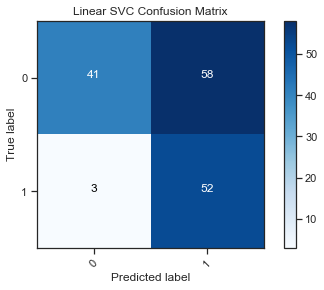

In [462]:
model = LSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_mtx = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2), title = 'Linear SVC Confusion Matrix')
plt.savefig('LSVC_conf.jpg', bbox_inches='tight')

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



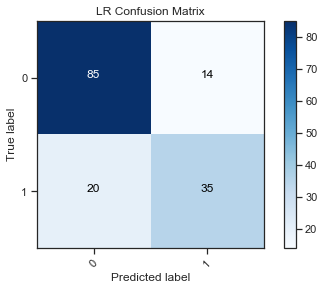

In [463]:
model = LR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_mtx = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2), title = 'LR Confusion Matrix')
plt.savefig('LR_conf.jpg', bbox_inches='tight')

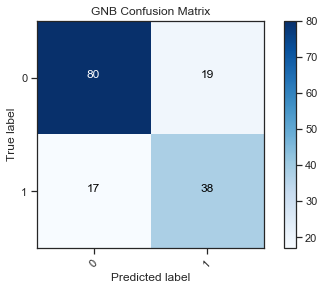

In [464]:
model = GNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_mtx = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2), title = 'GNB Confusion Matrix')
plt.savefig('GNB_conf.jpg', bbox_inches='tight')

### Feature Selection

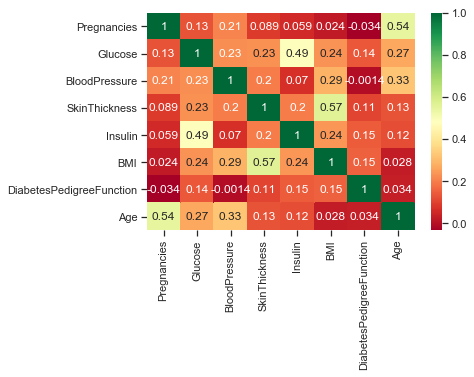

In [465]:
import seaborn as sns

sns.heatmap(data[data.columns[:8]].corr(), annot = True, cmap = 'RdYlGn')
plt.show
plt.savefig('feature.jpg', bbox_inches='tight')

In [466]:
# RFC used to find the correlation values 
model= RFC(n_estimators=100,random_state=42)
# Def X and Y
X = data.drop('Outcome', 1)
y = data['Outcome']
model.fit(X,y)
pd.Series(model.feature_importances_, index= X.columns).sort_values(ascending = False)

Insulin                     0.360962
Glucose                     0.158366
SkinThickness               0.143416
BMI                         0.087686
Age                         0.086385
DiabetesPedigreeFunction    0.065001
BloodPressure               0.050493
Pregnancies                 0.047691
dtype: float64

In [467]:
data2 = pd.DataFrame(data)
outcome2 = data2['Outcome']
new_feat = data2[['Insulin', 'Glucose','SkinThickness']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_feat, outcome2, test_size = 0.2, random_state = 42)

for clf, clf_name in zip(classifiers, classifier_names):
    clf.fit(X_train2, y_train2)
    y_pred2 = clf.predict(X_test2)
    scores2 = f1_score(y_test2, y_pred2)
    print(clf_name, scores2)

K nearest neighbors 0.7636363636363637
Decision Tree Classifier 0.7543859649122807
Linear SVC  0.6081871345029239
Logistic Regression 0.6464646464646464
Gaussian Naive Bayes 0.6199999999999999


C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



###  Cross Validation

In [468]:
kfold = KFold(n_splits = 10, random_state= 42)

xyz=[]
accuracy=[]
classifiers=['Linear Svm','Logistic Regression','KNN','Decision Tree', 'Gaussian Naives Bayes']
models=[LSVC(),LR(),KNNC(),DTClassifier(), GNB()]
for i in models:
    model = i
    cv_result = cross_val_score(model,data.drop('Outcome',axis=1),data['Outcome'], cv = kfold,scoring = "accuracy") 
    cv_result=cv_result
    xyz.append(cv_result.mean())
    accuracy.append(cv_result)

print(classifiers, xyz)

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklear

['Linear Svm', 'Logistic Regression', 'KNN', 'Decision Tree', 'Gaussian Naives Bayes'] [0.6134825700615174, 0.7786397812713602, 0.8515208475734791, 0.8477272727272729, 0.7643540669856461]


### GridSearchCV

In [469]:
def predict_labels(clf, features, target):
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred,  average='weighted')

In [470]:
from sklearn.ensemble import GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

loss = ['deviance', 'exponential']
n_estimators = [30, 60]
max_depth = [1, 2, 3, 4, 5]
random_state = [0, 24]
parameters =  {'loss': loss, 'n_estimators' : n_estimators, 'max_depth' : max_depth, 'random_state' : random_state}

# Initialize the classifier
clf = GradientBoostingClassifier()

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label=1)

# Perform grid search on the classifier using the f1_scorer as the scoring method
clf_grid_search = GridSearchCV(clf, parameters, scoring=f1_scorer, cv=5, verbose=0)
print (clf_grid_search)

# Fit the grid search object to the training data and find the optimal parameters
clf_grid_search.fit(X_train, y_train)

# Get the estimator
best_estimator = clf_grid_search.best_estimator_
print (best_estimator)

print ("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf_grid_search, X_test, y_test)))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  presort='auto',
  

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='auto',
                           random_state=24, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Made predictions in 0.0070 seconds.
Tuned model has a testing F1 score of 0.8639.


### Ensembling

#### Basic Ensembling

In [378]:

ensemble_all = VotingClassifier(estimators = [('Logistic Regression', LR(C=0.1)),('KNN', KNNC(n_neighbors = 7)),('Decision Tree',DTClassifier())], voting = 'soft', weights = [1,1,1]).fit(X_train, y_train)
print('Score: ', ensemble_all.score(X_test, y_test))

Score:  0.8506493506493507


C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



#### Boosting Algorithms

##### Utilizing LightGB and KNNC

In [379]:


random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 300

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=kfold,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:  5.1min finished
C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [380]:
knn_clf = KNNC( )

voting_clf = VotingClassifier(estimators=[ 
    ('lgbm_clf', lgbm_clf),
    ('knn', KNNC())], voting='soft', weights = [1,1])

params = {
      'knn__n_neighbors': np.arange(1,30)
      }
      
grid = GridSearchCV(estimator=voting_clf, param_grid=params, cv=kfold)

grid.fit(X,y)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Best Score:0.8880208333333334
Best Parameters: {'knn__n_neighbors': 25}


##### XGBoost Classifier

F1_score:  0.7927927927927927


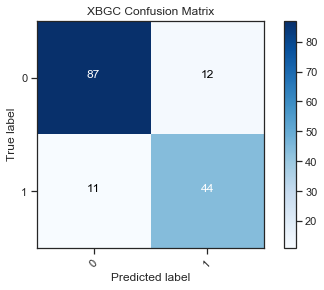

In [381]:
model = XGBC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores = f1_score(y_test, y_pred)
print('F1_score: ', scores)
confusion_mtx = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2), title = 'XBGC Confusion Matrix')


- XGBoost with Cross Validation

In [382]:
model_cross = cross_val_score(model,data.drop('Outcome',axis=1),data['Outcome'], cv = kfold,scoring = "accuracy")
print(model_cross.mean())

0.8867395762132604


##### Random Forest Classifier

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



F1_score:  0.8035714285714286


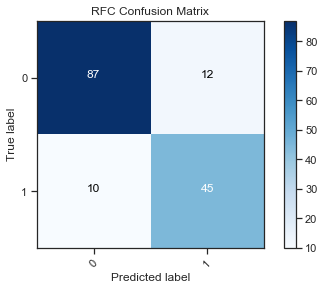

In [383]:
model = RFC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred)
confusion_mtx = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2), title = 'RFC Confusion Matrix')
print('F1_score: ', score)

- RFC with Cross Validation

In [384]:
model_cross = cross_val_score(model,data.drop('Outcome',axis=1),data['Outcome'], cv = kfold,scoring = "accuracy")
print(model_cross.mean())

0.8698222829801777


### Conclusion

It seems that LightGB Model with K-Nearest Neighbors is the best model with an accuracy of 88.8%. 
It should also be noted that both XGBoost and RFC (cross validation) accuracy is close to LightGB-KNN model and can also be used. The only reason I choose LightGBM is because it has lower run costs. 

##### END
